In [1]:
import pandas as pd
from premiere_analyse import *
from testZ import *
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import seaborn as sns
sns.set_style("white")

import numpy as np
import scipy.stats as st
%load_ext autoreload
%autoreload 2
%matplotlib inline 

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
############################################ PARAMETRES ###############################################
folder = 'Data/'
annonceur1 = 'annonceur1/annonceur1'
annonceur2 = 'annonceur2/annonceur2'
#######################################################################################################

data_name = {
    "a1c1": 'annonceur1_campaign1_visite_2pages',
    "a1c2": 'annonceur1_campaign2_visite_2pages',
    "a1c3": 'annonceur1_campaign3_visite_2pages',
    "a1c4": 'annonceur1_campaign4_visite_2pages',
    "a2c1produit": 'annonceur2_campaign1_visite_page_produit',
    "a2c1panier": 'annonceur2_campaign1_visite_panier',
#     "a2c1achat": 'annonceur2_campaign1_achat',
}

print("Alias des datasets :")
print(data_name)
# chargment des données
data_dict = {
    "a1c1": pd.read_hdf(folder + annonceur1 + '.hdf', key=data_name["a1c1"]),
    "a1c2": pd.read_hdf(folder + annonceur1 + '.hdf', key=data_name["a1c2"]),
    "a1c3": pd.read_hdf(folder + annonceur1 + '.hdf', key=data_name["a1c3"]),    
    "a1c4": pd.read_hdf(folder + annonceur1 + '.hdf', key=data_name["a1c4"]),
    "a2c1produit": pd.read_hdf(folder + annonceur2 + '.hdf', key=data_name["a2c1produit"]),
    "a2c1panier": pd.read_hdf(folder + annonceur2 + '.hdf', key=data_name["a2c1panier"]),
#     "a2c1achat": pd.read_hdf(folder + annonceur2 + '.hdf', key=data_name["a2c1achat"]),
}

Alias des datasets :
{'a1c1': 'annonceur1_campaign1_visite_2pages', 'a1c2': 'annonceur1_campaign2_visite_2pages', 'a1c3': 'annonceur1_campaign3_visite_2pages', 'a1c4': 'annonceur1_campaign4_visite_2pages', 'a2c1produit': 'annonceur2_campaign1_visite_page_produit', 'a2c1panier': 'annonceur2_campaign1_visite_panier'}


In [3]:
############################################ PARAMETRES ###############################################
freq_list = ["1D", "1W"]
#######################################################################################################

# calcul des taux pour une fréquence donnée
conv_count, conv_rate, pct_change = {}, {}, {}
for freq in freq_list:
    conv_count[freq], conv_rate[freq], pct_change[freq] = {}, {}, {}
    for name, data in data_dict.items():
        conv_count[freq][name] = conversion_count_resample(data, freq)
        conv_rate[freq][name] = conversion_rate_resample(data, freq)
        pct_change[freq][name] = (conv_rate[freq][name]["A"] - conv_rate[freq][name]["B"]) / conv_rate[freq][name]["B"]
        # attention il y a des NaN quand il y a pas de conversion du groupe B

# Visualisation des données brutes : nombre et taux de conversion

#### <center> Nombre de conversions pour différentes fréquences </center>

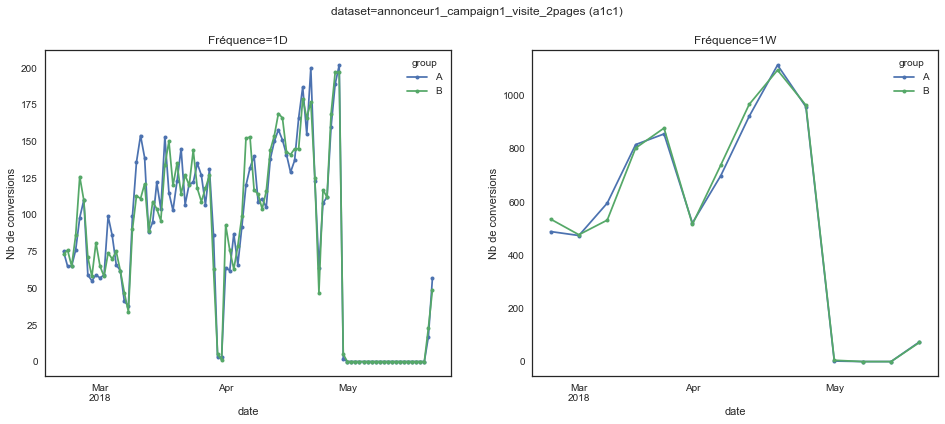

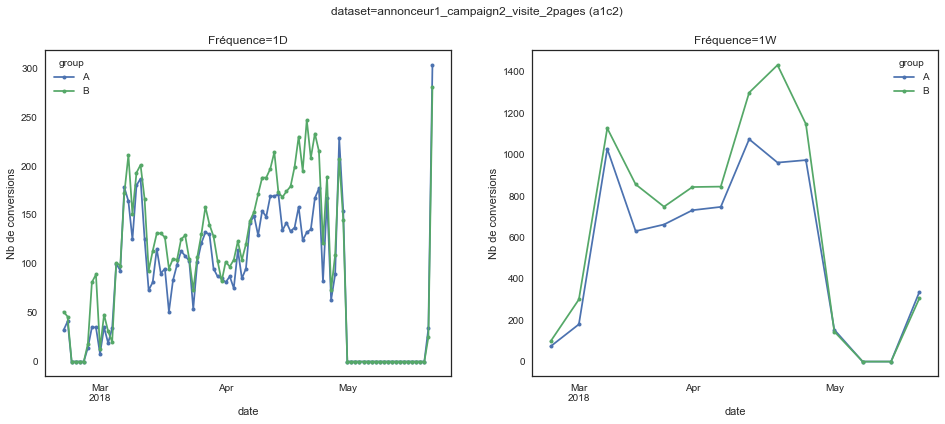

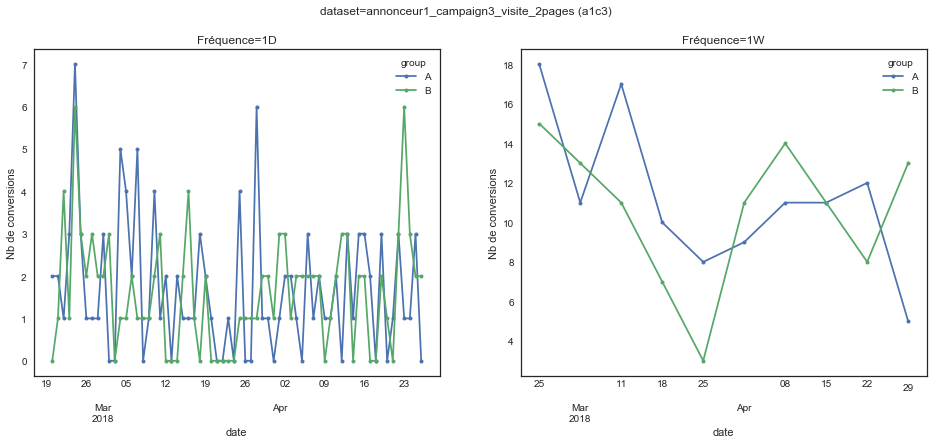

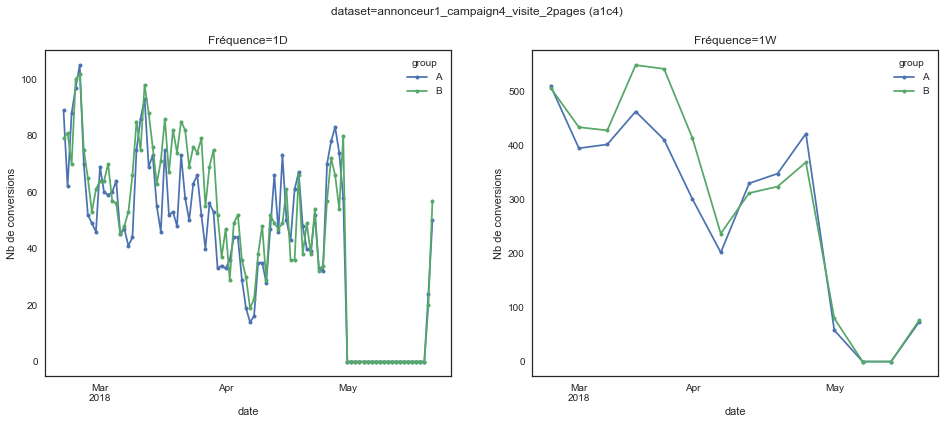

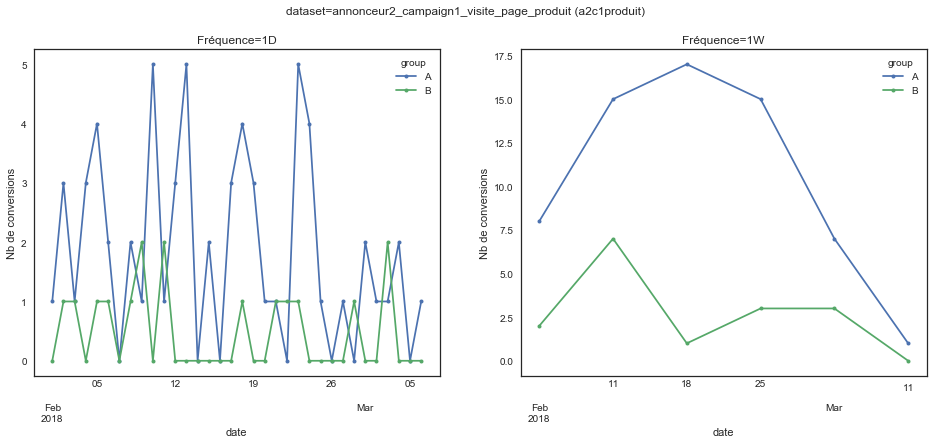

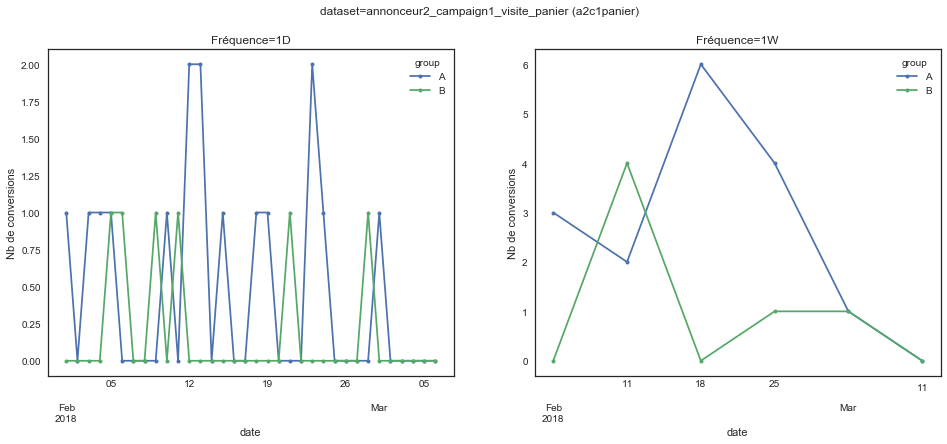

In [4]:
# trace des taux de conversion pour frequences differentes
display(Markdown("#### <center> Nombre de conversions pour différentes fréquences </center>"))
for name in data_dict:
    plt.figure(figsize=(16, 6))
    for i, freq in enumerate(freq_list):
        plt.subplot(1, len(freq_list), i+1)
        conv_count[freq][name].plot(ax=plt.gca(), marker="o", ms=4)
        plt.title(f"Fréquence={freq}")
        plt.ylabel('Nb de conversions')
    plt.suptitle(f'dataset={data_name[name]} ({name})')
    plt.show()

#### <center> Taux de conversion pour différentes fréquences </center>

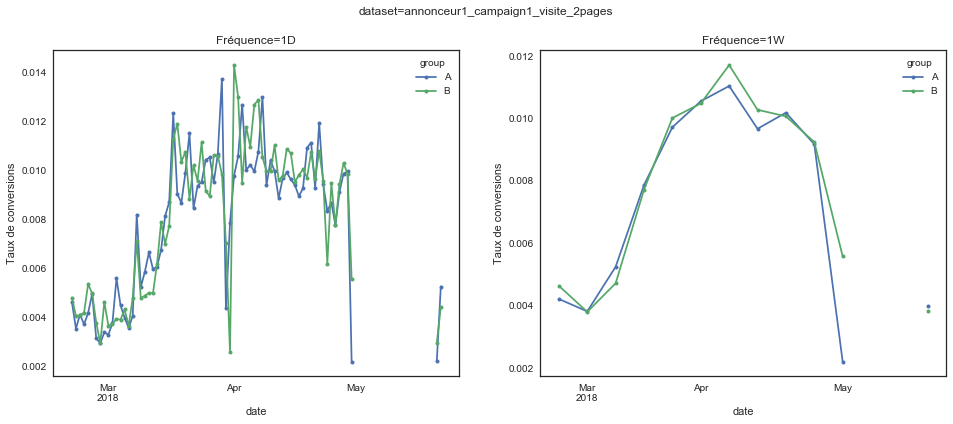

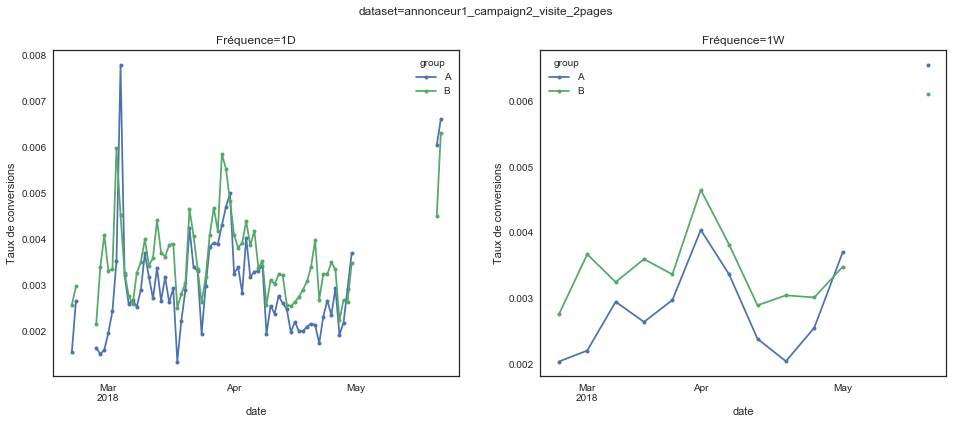

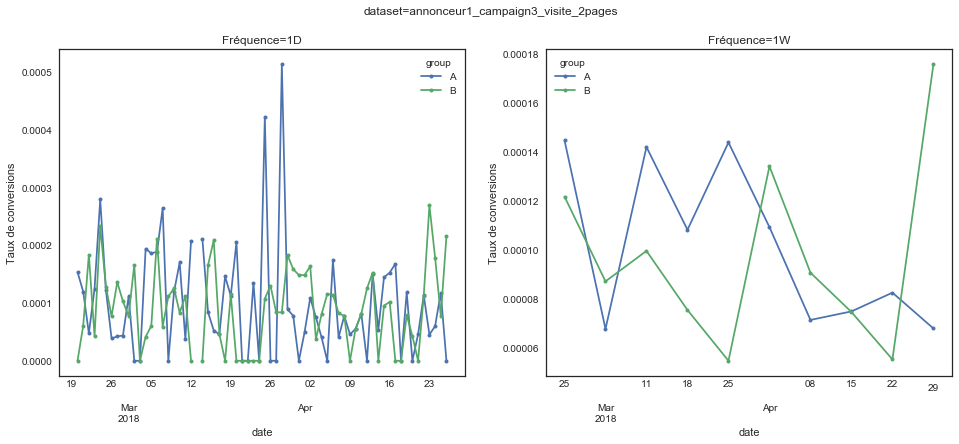

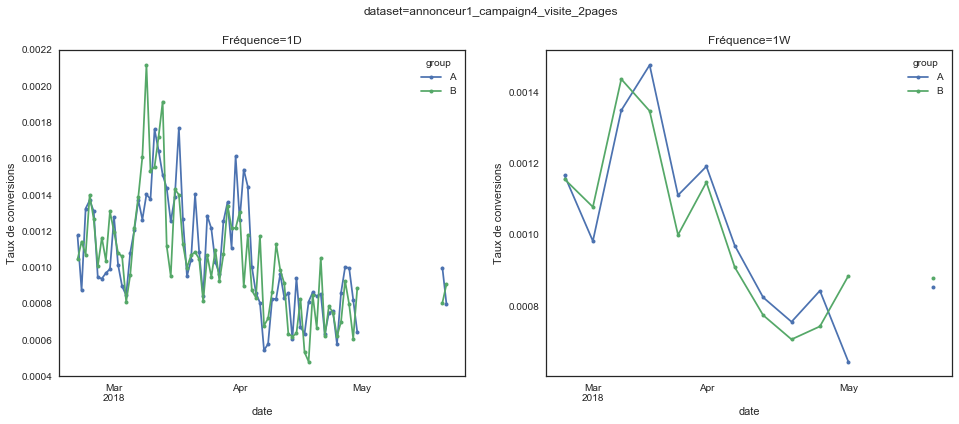

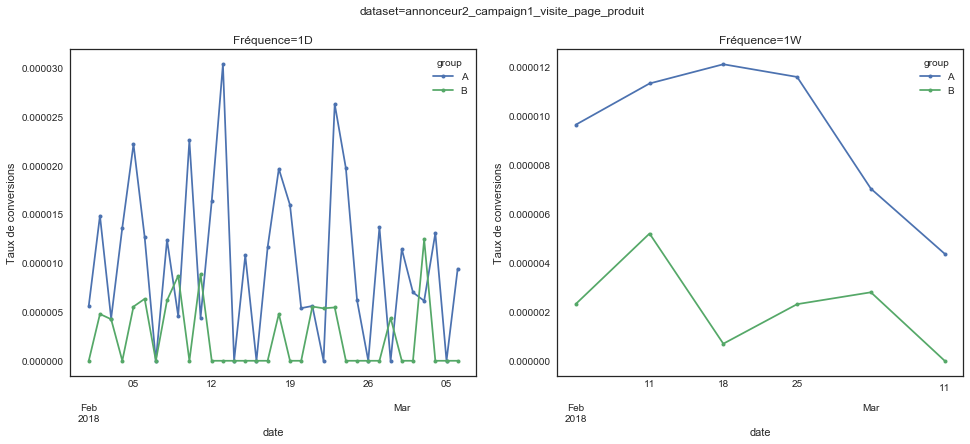

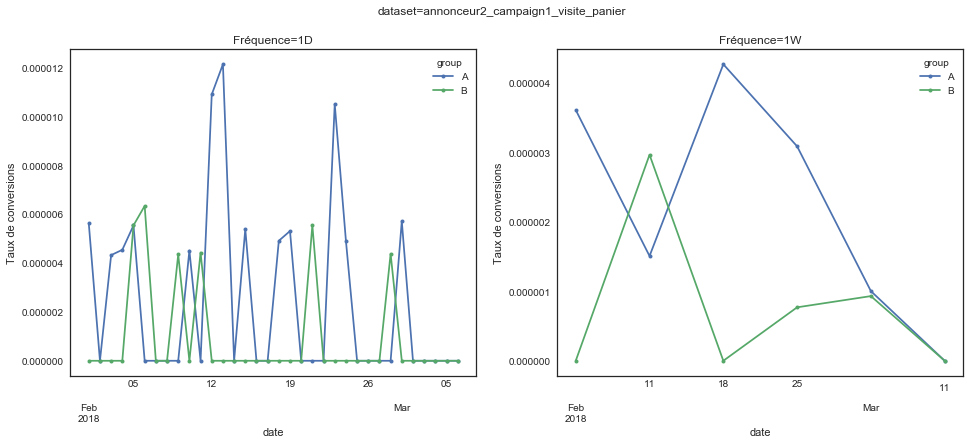

In [5]:
# trace des taux de conversion pour frequences differentes
display(Markdown("#### <center> Taux de conversion pour différentes fréquences </center>"))
for name in data_dict:
    plt.figure(figsize=(16, 6))
    for i, freq in enumerate(freq_list):
        plt.subplot(1, len(freq_list), i+1)
        conv_rate[freq][name].plot(ax=plt.gca(), marker="o", ms=4)
        plt.title(f"Fréquence={freq}")
        plt.ylabel('Taux de conversions')
    plt.suptitle(f'dataset={data_name[name]}')
    plt.show()

# 1) Différence relative entre les taux de conversion

+ Est-ce qu'il y a un pattern (journalier, hebdomadaire, mensuel, ...) dans la différence de taux de conversion ? 
+ Est-ce qu'on retrouve les mêmes patterns si on retrace les courbes par semaine/mois? Si non, pourquoi ?
+ Est-ce qu'il y a des différences entre campagnes ?

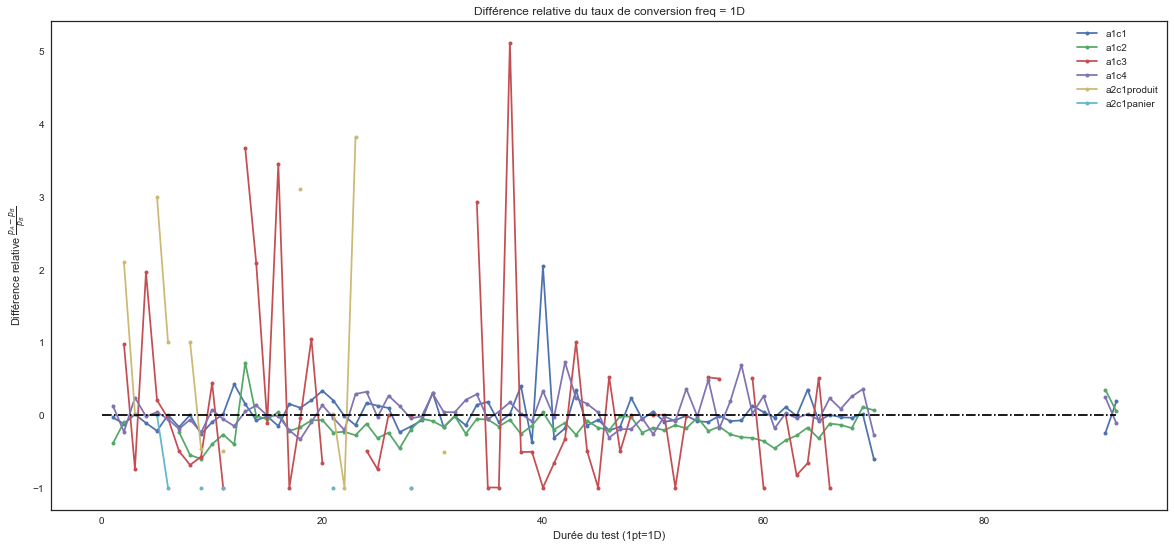

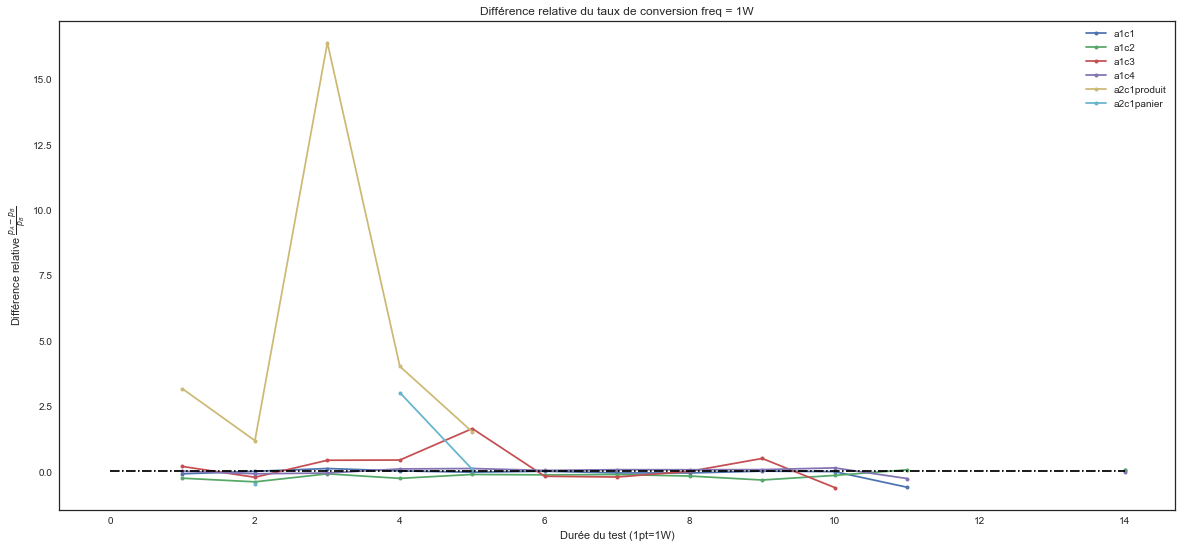

In [6]:
# trace des variations relatives pour frequences differentes
for freq in freq_list:
    plt.figure(figsize=(20, 9))
    for name in data_dict:
        series = pct_change[freq][name].reset_index(drop=True)
        series.index += 1
        series.plot(ax=plt.gca(), marker="o", ms=4, label=name)
    max_len = max([pct_change[freq][name].reset_index(drop=True).index.max() + 1for name in data_dict])    
    for threshold in [0.]:
        plt.plot(np.arange(max_len + 1), np.full(max_len + 1, threshold), ls="dashdot", c="black")
        
    plt.ylabel('Différence relative $\\frac{p_A - p_B}{p_B}$')
    plt.xlabel(f"Durée du test (1pt={freq})")
    plt.legend()
    plt.title(f"Différence relative du taux de conversion freq = {freq}")
    plt.show()

# 2) Z-test et p-value cumulées en fonction du temps

+ Est-ce qu'il y a des différences entre campagnes ?  
+ Est-ce que les valeurs du Z test et de la p value deviennent "stables" après un certain temps ?
+ Compter/visualiser le nombre de fois que la significativité change avec un pas d'un jour.
+ Combien de fois une variation dans un jour / une semaine / un mois en moyenne ? 
+ Comment ces résultats changent si on change le seuil de significativité (ex. 80% au lieu de 90%) ?

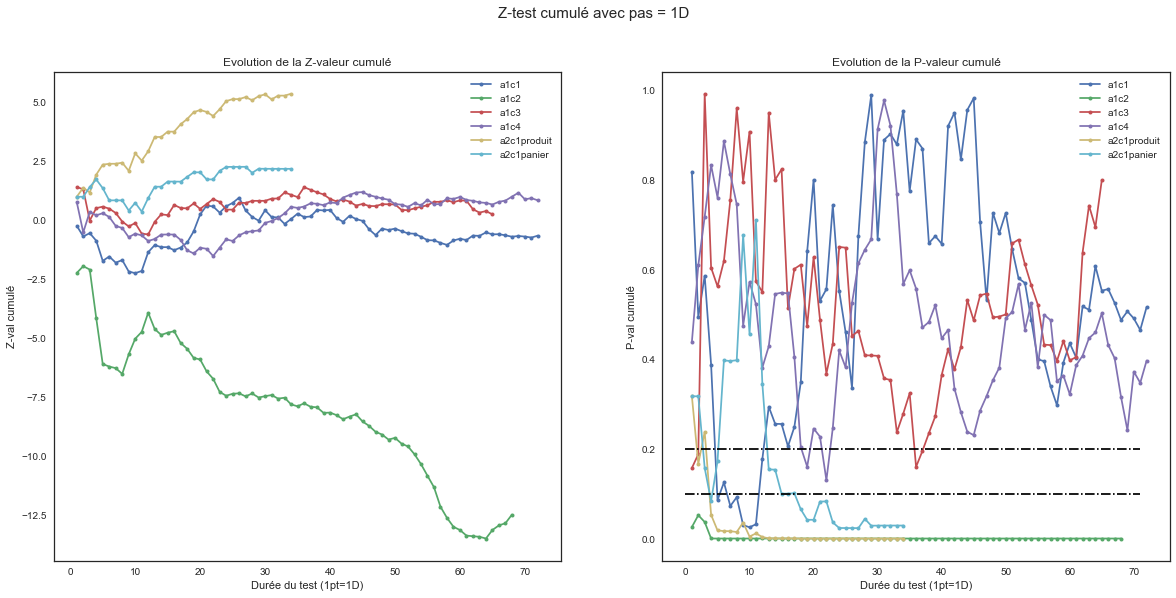

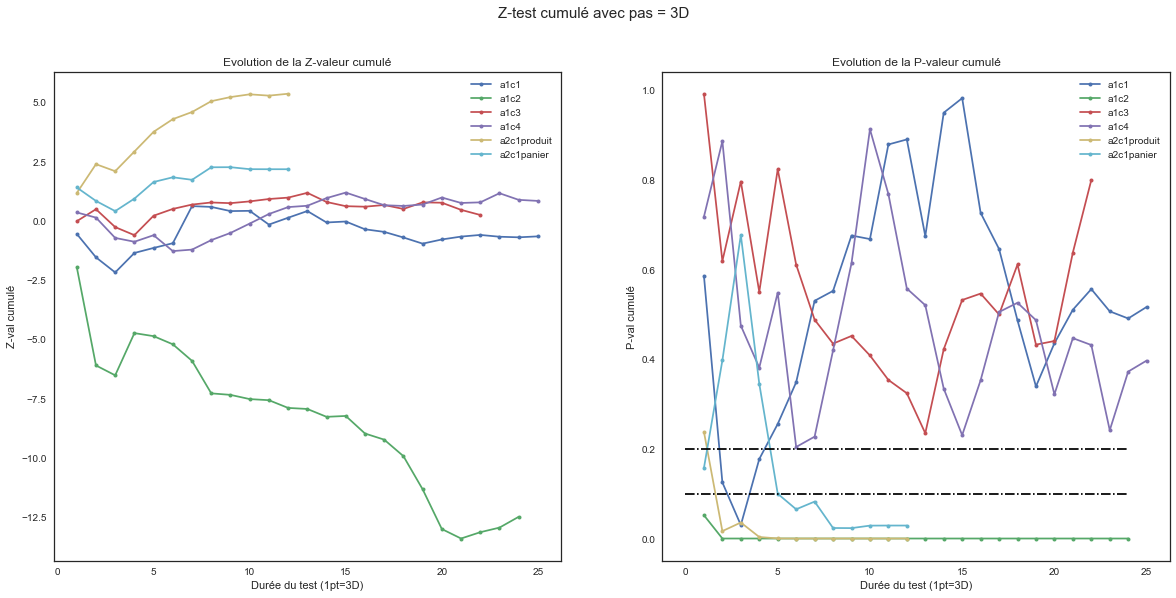

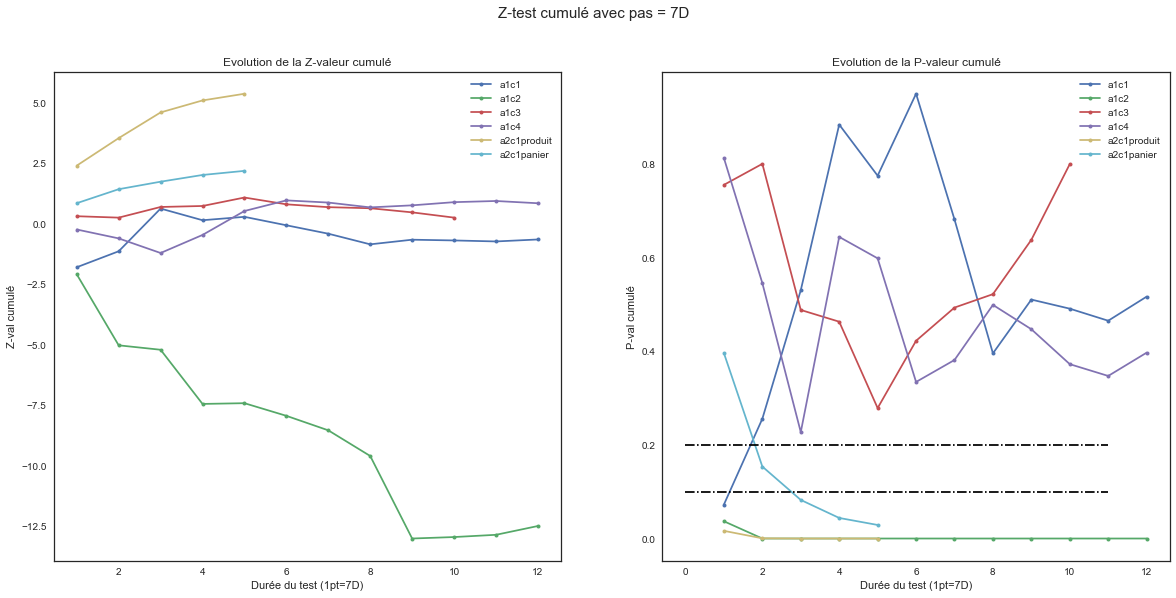

In [7]:
############################################ PARAMETRES ###############################################
freq_list = ["1D", "3D", "7D"]
#######################################################################################################

Z_cum, P_rej, p_cum = {}, {}, {}
for freq in freq_list:
    Z_cum[freq], P_rej[freq], p_cum[freq] = {}, {}, {}
    for name, data in data_dict.items():
        Z_cum[freq][name], P_rej[freq][name], p_cum[freq][name] = testZ_cum_frequency(data, freq=freq)

for freq in freq_list:
    plt.figure(figsize=(20, 9))

    plt.subplot(1, 2, 1)
    for name in data_dict:
        series = Z_cum[freq][name].reset_index(drop=True)
        series.index += 1
        series.plot(
            title='Evolution de la Z-valeur cumulé', 
            ax=plt.gca(), marker="o", ms=4, label=name,
        )
    plt.ylabel('Z-val cumulé')
    plt.xlabel(f"Durée du test (1pt={freq})")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for name in data_dict:
        series = P_rej[freq][name].reset_index(drop=True)
        series.index += 1
        series.plot(
            title='Evolution de la P-valeur cumulé',
            ax=plt.gca(), label=name, marker="o", ms=4,
        )
    
    max_len = max([len(Z_cum[freq][name]) for name in data_dict])    
    for threshold in [0.1, 0.2]:
        plt.plot(np.arange(max_len), np.full(max_len, threshold), ls="dashdot", c="black")
    plt.ylabel('P-val cumulé')
    plt.xlabel(f"Durée du test (1pt={freq})")
    plt.legend()
    
    plt.suptitle(f"Z-test cumulé avec pas = {freq}", size=15)
    plt.show();